# Deep Convloutional GAN (DCGAN)

- Referecnce : https://github.com/eriklindernoren/PyTorch-GAN

In [1]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Use MNIST Dataset & DataLoader

In [3]:
bs =128

dataset = datasets.MNIST("./mnist", train=True, download=True, 
                         transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=True)

torch.Size([128, 1, 32, 32]) tensor([3, 8, 2, 7, 1, 2, 2, 5, 8, 6, 7, 6, 2, 1, 8, 4, 1, 5, 4, 8, 2, 6, 2, 7,
        5, 2, 6, 8, 3, 4, 9, 3, 1, 4, 0, 3, 6, 9, 9, 0, 2, 6, 6, 5, 3, 9, 6, 7,
        6, 1, 0, 6, 8, 1, 9, 9, 6, 6, 3, 6, 6, 5, 3, 3, 0, 9, 8, 2, 2, 2, 0, 1,
        2, 4, 3, 8, 5, 8, 4, 7, 6, 1, 1, 1, 7, 4, 3, 6, 6, 1, 6, 1, 0, 8, 8, 6,
        7, 2, 6, 9, 9, 2, 8, 7, 6, 3, 9, 7, 8, 1, 6, 5, 3, 7, 6, 1, 3, 2, 8, 2,
        8, 2, 8, 7, 8, 8, 0, 2])


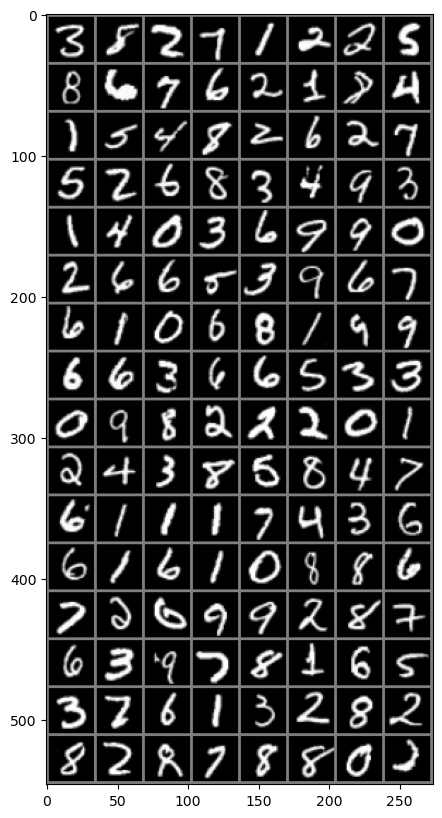

In [4]:
batch = next(iter(dataloader))
len(batch)
print(batch[0].shape, batch[1])

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(batch[0]))

## Define Generator & Discriminator
### Generator architecture
input random vector: 100 dim
* Linear: out_features 128 * 8 * 8
* BatchNorm2d
* Upsample: scale_factor 2
* Conv2d: out_channel: 128, kernel size 3, stride 1, padding 1
* BatchNorm2d
* LeakyReLU: 0.2
* Upsample: scale_factor 2
* Conv2d: out_channel: 64, kernel size 3, stride 1, padding 1
* BatchNorm
* LeakyReLU: 0.2
* Conv2d: out_channel: 1, kernel size 3, stride 1, padding 1
* Tanh

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.fc1 = nn.Linear(100, 128*8*8)
        self.bn1 = nn.BatchNorm2d(128)
        self.up = nn.Upsample(scale_factor=2)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(128, 128, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 1, 3, 1, 1)
        self.last_act = nn.Tanh()

    def forward(self, z):
        #### Implement Here ####
        #### Hint : z should be reshaped into 2d before going into bn layer
        z = self.fc1(z)
        img = z.view(-1, 128, 8, 8)
        img = self.bn1(img)
        img = self.act(self.bn2(self.conv1(self.up(img))))
        img = self.act(self.bn3(self.conv2(self.up(img))))
        img = self.last_act(self.conv3(img))
        
        return img

### Discriminator architecture
input: [1 , 32 , 32] image 
* Conv2d: out_channel: 16, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* Conv2d: out_channel: 32, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Conv2d: out_channel: 64, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Conv2d: out_channel: 128, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Linear: out_features 1
* Sigmoid

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.block1 = self.make_block(1, 16, False)
        self.block2 = self.make_block(16, 32)
        self.block3 = self.make_block(32, 64)
        self.block4 = self.make_block(64, 128)
        self.fc = nn.Linear(512, 1)
        self.last_act = nn.Sigmoid()
        
        
    def make_block(self, in_channel, out_channel, bn= True):
        #### Implement Here ####
        layers = [
            nn.Conv2d(in_channel, out_channel, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
        ]
        if bn:
            layers.append(nn.BatchNorm2d(out_channel))
        
        return nn.Sequential(*layers) 
        
        
    def forward(self, img):# [1, 32, 32]
        #### Implement Here ####
        img = self.block1(img)
        img = self.block2(img)
        img = self.block3(img)
        img = self.block4(img)
        x = img.view(img.size(0), -1)
        x = self.last_act(self.fc(x))
        
        return x


In [7]:
# Initialize generator and discriminator
G = Generator()
D = Discriminator()

In [8]:
from torchsummary import summary
summary(G, device = 'cpu', batch_size = -1, input_size = (100,))
summary(D, device = 'cpu', batch_size = -1, input_size = (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]         827,392
       BatchNorm2d-2            [-1, 128, 8, 8]             256
          Upsample-3          [-1, 128, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]         147,584
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
          Upsample-7          [-1, 128, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          73,792
       BatchNorm2d-9           [-1, 64, 32, 32]             128
        LeakyReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11            [-1, 1, 32, 32]             577
             Tanh-12            [-1, 1, 32, 32]               0
Total params: 1,049,985
Trainable params: 1,049,985
Non-trainable params: 0
---------------------------

## Weight Initialization

In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1: # Conv2d layer weights init
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1: # BatchNorm2d layer weights init
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# weight initialize
G.apply(weights_init_normal)
D.apply(weights_init_normal)

Discriminator(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## Define loss & Optimizer & model

In [10]:
# Loss function
criterion = torch.nn.BCELoss()

optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.9999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.9999))

## Start Training

In [11]:
G, D = G.to(device), D.to(device)
os.makedirs("./dcgan_images", exist_ok=True)
epochs = 20

[Epoch 0/20] [Batch 0/468] [D loss: 0.712657] [G loss: 0.691292]


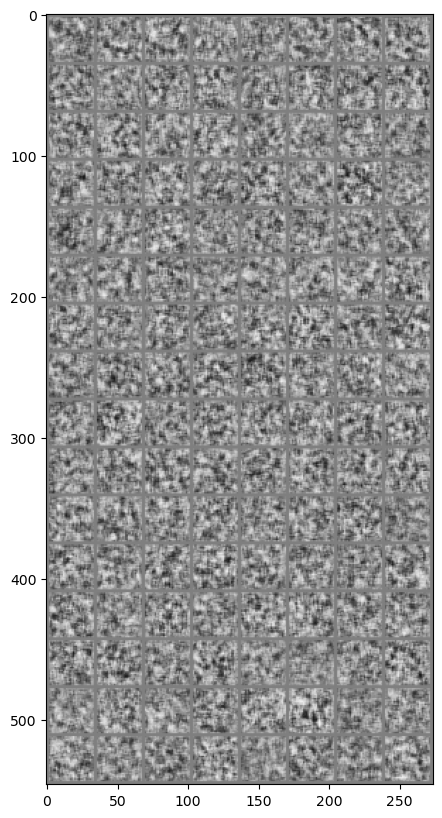

[Epoch 0/20] [Batch 100/468] [D loss: 0.703895] [G loss: 0.762286]
[Epoch 0/20] [Batch 200/468] [D loss: 0.701670] [G loss: 0.719977]
[Epoch 0/20] [Batch 300/468] [D loss: 0.692263] [G loss: 0.642181]
[Epoch 0/20] [Batch 400/468] [D loss: 0.656558] [G loss: 0.712144]
[Epoch 1/20] [Batch 32/468] [D loss: 0.615388] [G loss: 0.840047]
[Epoch 1/20] [Batch 132/468] [D loss: 0.537893] [G loss: 1.018019]
[Epoch 1/20] [Batch 232/468] [D loss: 0.565932] [G loss: 0.854062]
[Epoch 1/20] [Batch 332/468] [D loss: 0.517727] [G loss: 0.999247]
[Epoch 1/20] [Batch 432/468] [D loss: 0.508406] [G loss: 0.821506]
[Epoch 2/20] [Batch 64/468] [D loss: 0.565357] [G loss: 1.287958]
[Epoch 2/20] [Batch 164/468] [D loss: 0.560986] [G loss: 1.168979]
[Epoch 2/20] [Batch 264/468] [D loss: 0.456152] [G loss: 0.999344]
[Epoch 2/20] [Batch 364/468] [D loss: 0.521402] [G loss: 1.038243]
[Epoch 2/20] [Batch 464/468] [D loss: 0.393346] [G loss: 0.814689]
[Epoch 3/20] [Batch 96/468] [D loss: 0.402544] [G loss: 1.309539

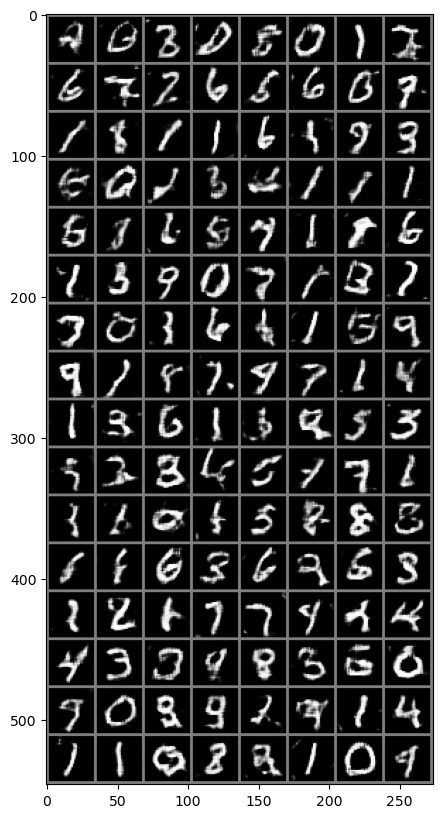

[Epoch 4/20] [Batch 228/468] [D loss: 0.411134] [G loss: 1.741865]
[Epoch 4/20] [Batch 328/468] [D loss: 0.334121] [G loss: 1.215875]
[Epoch 4/20] [Batch 428/468] [D loss: 0.323163] [G loss: 1.930374]
[Epoch 5/20] [Batch 60/468] [D loss: 0.511325] [G loss: 1.971859]
[Epoch 5/20] [Batch 160/468] [D loss: 0.262632] [G loss: 0.978957]
[Epoch 5/20] [Batch 260/468] [D loss: 0.276559] [G loss: 1.665367]
[Epoch 5/20] [Batch 360/468] [D loss: 0.455647] [G loss: 1.705097]
[Epoch 5/20] [Batch 460/468] [D loss: 0.301767] [G loss: 1.233565]
[Epoch 6/20] [Batch 92/468] [D loss: 0.368176] [G loss: 1.972386]
[Epoch 6/20] [Batch 192/468] [D loss: 0.273989] [G loss: 1.553939]
[Epoch 6/20] [Batch 292/468] [D loss: 0.295916] [G loss: 1.288189]
[Epoch 6/20] [Batch 392/468] [D loss: 0.263558] [G loss: 1.462289]
[Epoch 7/20] [Batch 24/468] [D loss: 0.247578] [G loss: 1.843862]
[Epoch 7/20] [Batch 124/468] [D loss: 0.353966] [G loss: 1.227160]
[Epoch 7/20] [Batch 224/468] [D loss: 0.218493] [G loss: 2.056075

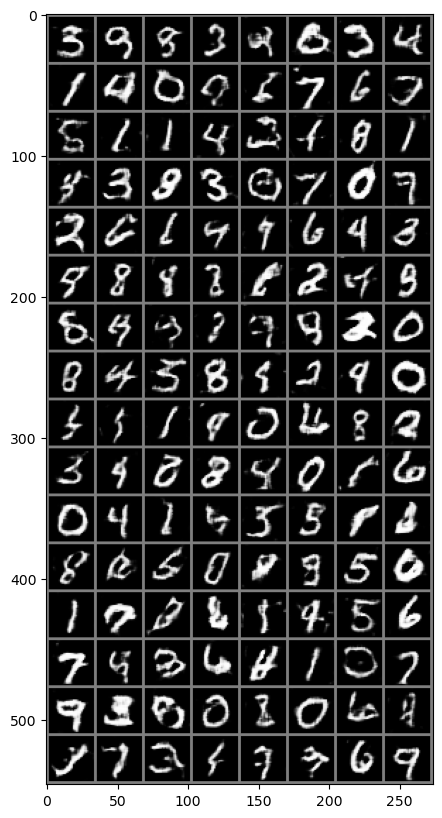

[Epoch 8/20] [Batch 356/468] [D loss: 0.270873] [G loss: 1.933786]
[Epoch 8/20] [Batch 456/468] [D loss: 0.233504] [G loss: 2.198966]
[Epoch 9/20] [Batch 88/468] [D loss: 0.348550] [G loss: 0.867037]
[Epoch 9/20] [Batch 188/468] [D loss: 0.254223] [G loss: 0.769861]
[Epoch 9/20] [Batch 288/468] [D loss: 0.437636] [G loss: 2.575974]
[Epoch 9/20] [Batch 388/468] [D loss: 0.138883] [G loss: 3.079453]
[Epoch 10/20] [Batch 20/468] [D loss: 0.268712] [G loss: 3.176196]
[Epoch 10/20] [Batch 120/468] [D loss: 0.235296] [G loss: 1.456751]
[Epoch 10/20] [Batch 220/468] [D loss: 0.175155] [G loss: 2.504330]
[Epoch 10/20] [Batch 320/468] [D loss: 0.306579] [G loss: 1.956272]
[Epoch 10/20] [Batch 420/468] [D loss: 0.153421] [G loss: 1.865824]
[Epoch 11/20] [Batch 52/468] [D loss: 0.266298] [G loss: 2.769581]
[Epoch 11/20] [Batch 152/468] [D loss: 0.283381] [G loss: 1.571636]
[Epoch 11/20] [Batch 252/468] [D loss: 0.277645] [G loss: 1.685797]
[Epoch 11/20] [Batch 352/468] [D loss: 0.202557] [G loss:

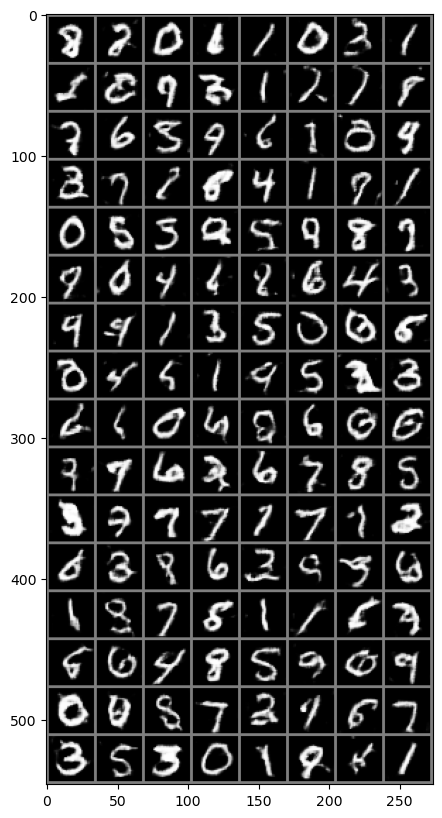

[Epoch 13/20] [Batch 16/468] [D loss: 0.159658] [G loss: 1.917282]
[Epoch 13/20] [Batch 116/468] [D loss: 0.179233] [G loss: 1.848938]
[Epoch 13/20] [Batch 216/468] [D loss: 0.341285] [G loss: 1.836896]
[Epoch 13/20] [Batch 316/468] [D loss: 0.225700] [G loss: 3.979228]
[Epoch 13/20] [Batch 416/468] [D loss: 0.121060] [G loss: 1.599954]
[Epoch 14/20] [Batch 48/468] [D loss: 0.138840] [G loss: 1.611540]
[Epoch 14/20] [Batch 148/468] [D loss: 0.232999] [G loss: 3.009314]
[Epoch 14/20] [Batch 248/468] [D loss: 0.222873] [G loss: 2.789422]
[Epoch 14/20] [Batch 348/468] [D loss: 0.111086] [G loss: 2.801273]
[Epoch 14/20] [Batch 448/468] [D loss: 0.122292] [G loss: 2.283533]
[Epoch 15/20] [Batch 80/468] [D loss: 0.123580] [G loss: 2.733238]
[Epoch 15/20] [Batch 180/468] [D loss: 0.252027] [G loss: 1.400857]
[Epoch 15/20] [Batch 280/468] [D loss: 0.224851] [G loss: 4.412763]
[Epoch 15/20] [Batch 380/468] [D loss: 0.082450] [G loss: 3.822251]
[Epoch 16/20] [Batch 12/468] [D loss: 0.087638] [G 

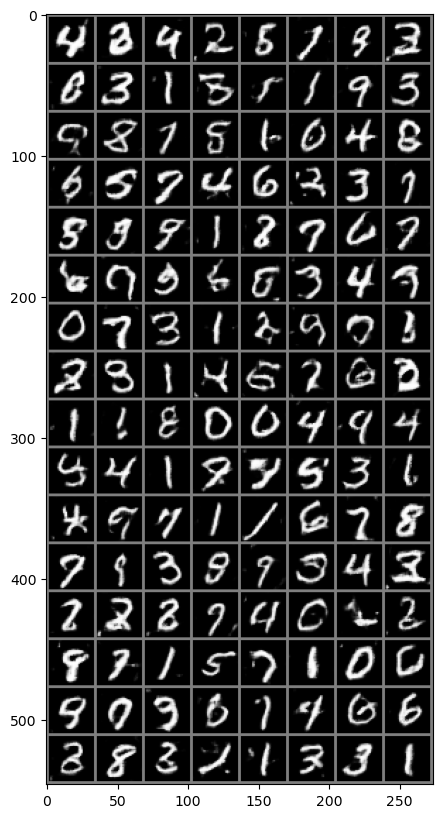

[Epoch 17/20] [Batch 144/468] [D loss: 0.259504] [G loss: 3.538337]
[Epoch 17/20] [Batch 244/468] [D loss: 0.282816] [G loss: 1.090419]
[Epoch 17/20] [Batch 344/468] [D loss: 0.121799] [G loss: 2.197956]
[Epoch 17/20] [Batch 444/468] [D loss: 0.184105] [G loss: 2.583280]
[Epoch 18/20] [Batch 76/468] [D loss: 0.207702] [G loss: 1.365165]
[Epoch 18/20] [Batch 176/468] [D loss: 0.388306] [G loss: 3.064442]
[Epoch 18/20] [Batch 276/468] [D loss: 0.155077] [G loss: 2.152011]
[Epoch 18/20] [Batch 376/468] [D loss: 0.198496] [G loss: 4.431388]
[Epoch 19/20] [Batch 8/468] [D loss: 0.227792] [G loss: 2.452558]
[Epoch 19/20] [Batch 108/468] [D loss: 0.113217] [G loss: 1.827400]
[Epoch 19/20] [Batch 208/468] [D loss: 0.086944] [G loss: 3.541639]
[Epoch 19/20] [Batch 308/468] [D loss: 0.446604] [G loss: 0.798212]
[Epoch 19/20] [Batch 408/468] [D loss: 0.098512] [G loss: 2.799057]


In [12]:
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):

        real_imgs = real_imgs.to(device)

        # Sample noise as generator input
        z = torch.Tensor(np.random.normal(0, 1, (real_imgs.shape[0], 100))).to(device)

        # -----------------
        #  Train Generator
        # -----------------
        #### Implement Here ####
        gen_imgs = G(z)
        ones = torch.ones((gen_imgs.size(0), 1)).to(device)
        zeros = torch.zeros((gen_imgs.size(0), 1)).to(device)
        
        optimizer_G.zero_grad()
        g_loss = criterion(D(gen_imgs), ones)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        #### Implement Here ####
        optimizer_D.zero_grad()
        fake_loss = criterion(D(gen_imgs.detach()), zeros)
        real_loss = criterion(D(real_imgs), ones)
        d_loss = (fake_loss + real_loss)/2
        d_loss.backward()
        optimizer_D.step()
        

        batches_done = epoch * len(dataloader) + i

        if batches_done % 100 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        if batches_done % 2000 == 0:
            save_image(gen_imgs.data, "dcgan_images/%06d.png" % batches_done, nrow=8, normalize=True)
            imshow(torchvision.utils.make_grid(gen_imgs.cpu()))

## Inference
- Check noise space

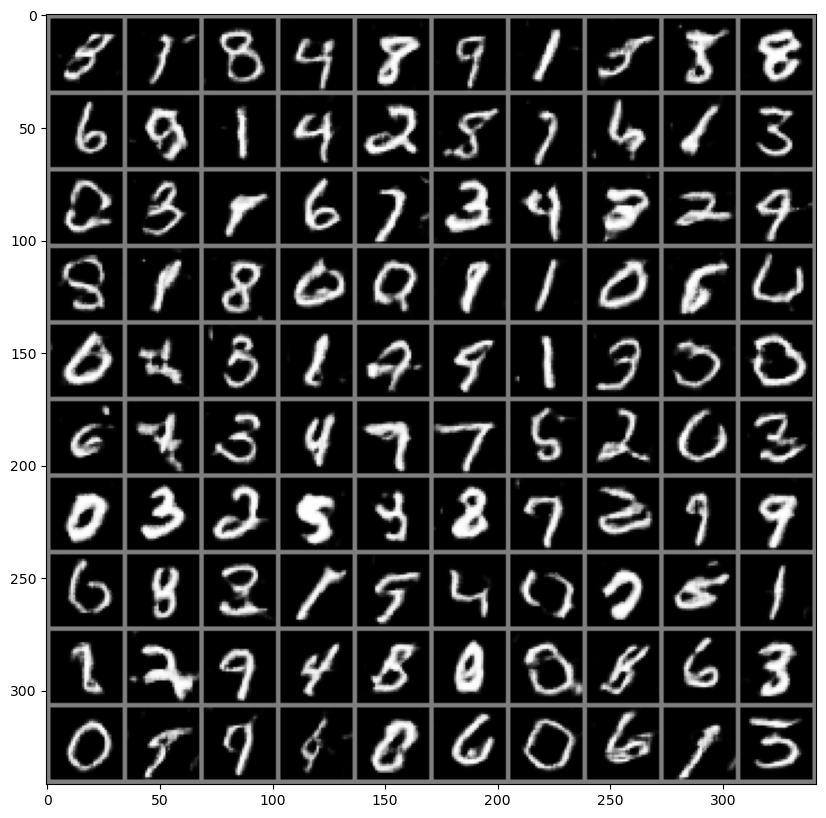

In [13]:
G.eval()
D.eval()

# 랜덤 노이즈(noise) 샘플링
z = torch.normal(mean=0, std=1, size=(100, 100)).to(device)

# 이미지 생성
gen_img = G(z)

imshow(torchvision.utils.make_grid(gen_img.detach().cpu(), nrow=10))

### Vector arithmetic 
- Pick three samples of cluster and take mean

In [14]:
ones = (z[0].unsqueeze(0) + z[84].unsqueeze(0) + z[74].unsqueeze(0)) / 3
sevens = (z[60].unsqueeze(0) + z[36].unsqueeze(0) + z[32].unsqueeze(0)) / 3
nines = (z[4].unsqueeze(0) + z[34].unsqueeze(0) + z[59].unsqueeze(0)) / 3

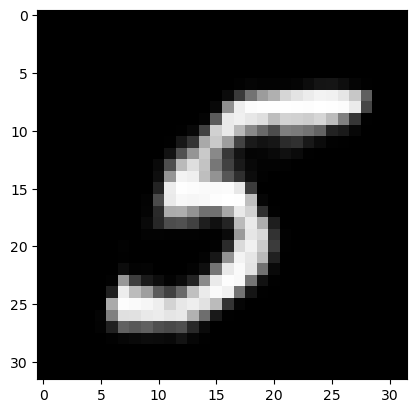

In [15]:
# ones
gen_img = G(ones).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

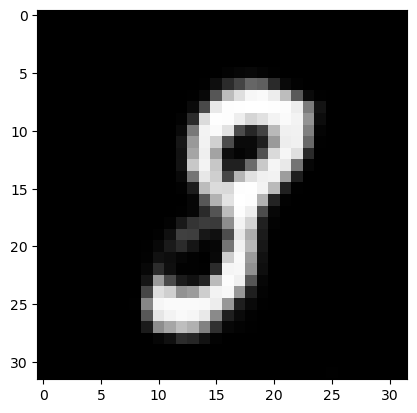

In [16]:
# sevens
gen_img = G(sevens).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

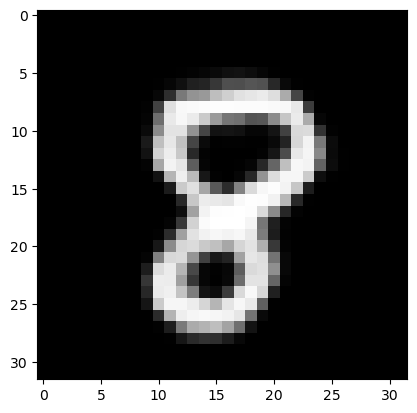

In [17]:
# twos
gen_img = G(nines).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

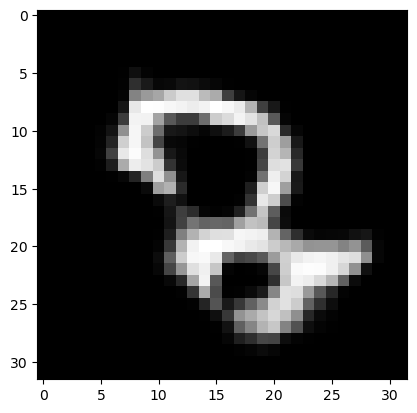

In [18]:
# vector_arithmetic
gen_vec = - ones + nines
gen_img = G(gen_vec).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

### Noise Interpolation Visualize
- interpolate noise vector and visualize

torch.Size([10, 1, 32, 32])


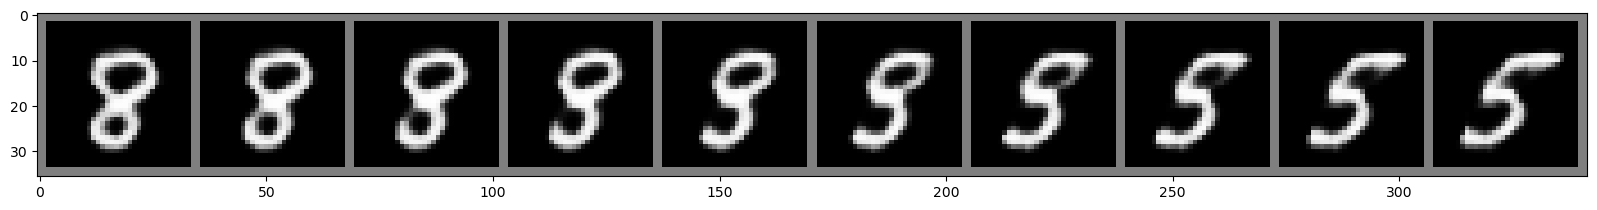

In [19]:
num_inter = 10
current = torch.Tensor(size=(num_inter, 100)).to(device)
for i in range(num_inter):
    current[i] = (ones.squeeze(0) * (i / (num_inter-1)) + nines.squeeze(0) * (((num_inter-1) - i) / (num_inter-1)))

gen_img = G(current).detach().cpu()
print(gen_img.shape)
imshow(torchvision.utils.make_grid(gen_img, nrow=num_inter))